## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

[GeoJson](https://tools.ietf.org/html/rfc7946#section-3.1.7) is a good way to add data on top of an ipyleaflet map.

For other backgrounds than open streets, you can alter the ipyleaflet.py file to point to one of [these map providers](https://leaflet-extras.github.io/leaflet-providers/preview/)

In [63]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [64]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
import pylab as plt

import sys
sys.path.append('./lib')

from leaflet import *

In [65]:
data_dir = "../../Data/Weather/"
from pickle import load
mea = 'TMIN'
fileindex = 'SSSSBBSS'
with open(data_dir+'/%s_residuals_PCA_%s.pickle' % (fileindex, mea),'rb') as file:
    Res_eig=load(file)
print Res_eig.keys()

#stations.pkl
with open(data_dir+'/stations.pkl','rb') as file:
    Stations=load(file)
Stations.head()


['eigen-vecs', 'stations']


,latitude,longitude,elevation,state,name,GSNFLAG,HCNFLAG,WMOID
ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0
AF000040930,35.3170,69.0170,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930.0
AG000060390,36.7167,3.2500,24.0,NaN,ALGER-DAR EL BEIDA,GSN,NaN,60390.0


In [66]:
import pandas as pd
Eig=pd.DataFrame(Res_eig['eigen-vecs'].transpose())
Eig.head()

,0,1,2,3
0,-0.142556,-0.085819,0.058713,-0.115980
1,-0.143248,0.046293,0.005767,0.179039
2,0.005363,0.020111,-0.018598,0.023793
3,0.014563,-0.001818,0.005137,0.025795
4,0.011000,0.005032,0.002779,0.017263


In [67]:
Eig['station']=Res_eig['stations']
Eig=Eig.set_index('station')
print Res_eig['stations'][:5]
Eig.head()

[u'USC00020855', u'USR0000AGLO', u'USC00029622', u'USC00028356', u'USC00026320']


,0,1,2,3
station,,,,
USC00020855,-0.142556,-0.085819,0.058713,-0.115980
USR0000AGLO,-0.143248,0.046293,0.005767,0.179039
USC00029622,0.005363,0.020111,-0.018598,0.023793
USC00028356,0.014563,-0.001818,0.005137,0.025795
USC00026320,0.011000,0.005032,0.002779,0.017263


In [68]:
table=Eig.join(Stations,how='left')

In [69]:
table=table[['name','latitude','longitude','elevation',0,1,2,3]]
table.head(4)

,name,latitude,longitude,elevation,0,1,2,3
station,,,,,,,,
USC00020855,BLUE,33.5833,-109.1667,1652.0,-0.142556,-0.085819,0.058713,-0.115980
USR0000AGLO,GLOBE ARIZONA,33.3503,-110.6519,1112.5,-0.143248,0.046293,0.005767,0.179039
USC00029622,YOUNG,34.1000,-110.9333,1539.8,0.005363,0.020111,-0.018598,0.023793
USC00028356,SUPERSTITION MTN,33.3667,-111.4333,598.0,0.014563,-0.001818,0.005137,0.025795


In [70]:
import pylab as plt
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Map

In [71]:
min_lat,max_lat,min_long,max_long = box = (min(table['latitude']),max(table['latitude']),min(table['longitude']),max(table['longitude']))
space = (max_lat - min_lat) / 5.0
min_lat -= space
max_lat += space
min_long -=space
max_long += space
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9
m = Map(default_tiles=TileLayer(opacity=0.6), center=center, zoom=zoom)
r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
for index,row in table.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    for col in range(4):
        _coef=row[col]
        if np.isnan(_coef):
            continue
        r=abs(_coef)/5
        #print r
        color=colors[col]
        signs=[[+1,+1],[+1,-1],[-1,-1],[-1,+1]]
        lat_sign,long_sign=signs[col]
        triangle=[(_lat,_long),(_lat+lat_sign*r,_long),(_lat,_long+long_sign*r),(_lat,_long)]
        if _coef<0:
            poly= Polygon(locations=triangle, weight=0,
                    color=color, opacity=0, fill_opacity=0.7,
                    fill_color=color)
        else:
            poly= Polygon(locations=triangle, weight=2,
                    color=color, opacity=0.8, fill_opacity=0,
                    fill_color=color)
        m +=poly   
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

KeyError: 'avg(coeff_1)'

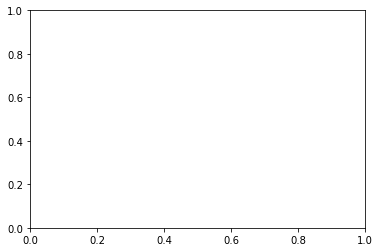

In [72]:
%matplotlib inline
table.plot.scatter(x='elevation',y='avg(coeff_1)');